In [9]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
N_CLASSES = 2
N_HIDDEN_UNITS = 64
N_EPOCHS = 50  # 50
BATCH_SIZE = 1024  # 1024
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [11]:
file_info = [N_HIDDEN_UNITS, BATCH_SIZE, N_EPOCHS]
dumps_dir = "nhid-{}_bat-{}_nepoc-{}/dumps/".format(*file_info)
logs_dir = "nhid-{}_bat-{}_nepoc-{}/logs/".format(*file_info)

history = pickle.load(open(dumps_dir + 'history.p', "rb"))
predictions = pickle.load(open(dumps_dir + 'predictions.p', "rb"))

In [12]:
ckpt = tf.train.get_checkpoint_state(logs_dir)

saver = tf.train.Saver()

with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, logs_dir + "har.ckpt")

INFO:tensorflow:Restoring parameters from nhid-64_bat-1024_nepoc-50/logs/har.ckpt


In [4]:
df=pd.read_csv('TYPASD.csv')
# df.head(22)
df.info()

RANDOM_SEED = 42
N_TIME_STEPS = 250
N_FEATURES = 128 #128
step = 10 # 20
segments = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    ch = []
    for j in range(0, N_FEATURES):
        ch.append(df.iloc[:, j].values[i: i + N_TIME_STEPS])
    segments.append(ch)
    
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    label = stats.mode(df['Label'][i: i + N_TIME_STEPS])[0][0]
    labels.append(label)
labelsl = np.asarray(pd.get_dummies(labels), dtype = np.float32)
#print(labelsl)

reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labelsl, test_size=0.3, random_state=RANDOM_SEED)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381750 entries, 0 to 381749
Columns: 129 entries, CH1 to Label
dtypes: float64(129)
memory usage: 375.7 MB


In [13]:
N_EPOCHS = 5
N_TIME_STEPS = 250
N_FEATURES = 128 #128
LEARNING_RATE = 0.0025

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred_Y, labels = Y)) + l2

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# history2 = dict(test_loss=[], test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for i in range(1, N_EPOCHS + 1):

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})
    
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
    
    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

C:\Users\hp\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 1 test accuracy: 0.508431613445282 loss: 8.125000953674316
epoch: 2 test accuracy: 0.508431613445282 loss: 8.125000953674316
epoch: 3 test accuracy: 0.508431613445282 loss: 8.125000953674316
epoch: 4 test accuracy: 0.508431613445282 loss: 8.125000953674316
epoch: 5 test accuracy: 0.508431613445282 loss: 8.125000953674316

final results: accuracy: 0.508431613445282 loss: 8.125000953674316


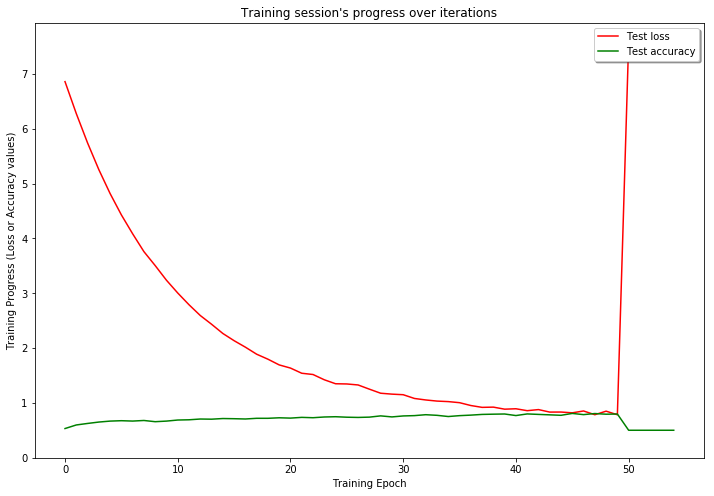

In [7]:
plt.figure(figsize=(12, 8))

# plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
# plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()